In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
from sklearn.metrics import mean_squared_error
import pickle
from datetime import timedelta as timedelta
from dateutil.relativedelta import relativedelta
from scipy.stats import *
# import datetime as dt

from support import *
from features.feature_ts import genX
from experiment.algorithms.cluster_prep import *
from Gauss_fit_functions import extractFIT, extractToPs , gauss, straight_line

c:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\os.py
c:\Users\Jason\thesis_project


# Load the Synthetic Profiles

## Flatten the Measured and synthetic data

In [2]:
# id = 1186

# Load in the measured data
measured_data = pd.read_csv("Measured_Profiles_Missing_days_replaced_sorted_lenient.csv")
measured_data['date'] = pd.to_datetime(measured_data['date'])
measured_data['date'] = measured_data['date'].apply(lambda x: x.date())
measured_data.set_index(['ProfileID', 'date'], inplace = True)
# measured_data.drop(['ProfileID.1'], axis = 1, inplace = True)

# Flatten the  measured data
temp = measured_data.copy()
flat_meas_df = temp.stack().reset_index()
flat_meas_df.columns = [ 'ProfileID', 'date', 'hour', 'A']
flat_meas_df['kWh'] = flat_meas_df['A']*230/1000
flat_meas_df.set_index(['ProfileID'], inplace = True)
flat_meas_df

# Load in the synthetic data
synthetic_data = pd.read_csv("CSV_Exclude/Synthetic_Profiles_with_Dates.csv")
synthetic_data.set_index(['ProfileID', 'date'], inplace = True)

# Flatten the synthetic data
temp = synthetic_data.copy()
flat_synth_df = temp.stack().reset_index()
flat_synth_df.columns = [ 'ProfileID', 'date', 'hour', 'A']
flat_synth_df['kWh'] = flat_synth_df['A']*230/1000
flat_synth_df.set_index(['ProfileID'], inplace = True)
flat_synth_df

,date,hour,A,kWh
ProfileID,,,,
1,1994-01-01,0,1.492697,0.343320
1,1994-01-01,1,1.518544,0.349265
1,1994-01-01,2,1.586362,0.364863
1,1994-01-01,3,1.720328,0.395675
1,1994-01-01,4,1.912825,0.439950
...,...,...,...,...
12029036,1994-12-31,19,4.980843,1.145594
12029036,1994-12-31,20,5.331693,1.226289
12029036,1994-12-31,21,4.586161,1.054817


In [3]:
ids = pd.read_pickle("Ids_of_users_with_atleast_400days_of_data.pkl")

In [4]:
flat_meas_df_filtered = flat_meas_df[flat_meas_df.index.isin(ids)]
flat_synth_df_filtered = flat_synth_df[flat_synth_df.index.isin(ids)]


In [5]:
profileIDs = np.intersect1d(flat_synth_df_filtered.index.unique(), flat_meas_df_filtered.index.unique())

In [8]:
flat_synth_df_filtered

,date,hour,A,kWh
ProfileID,,,,
1185,1994-01-01,0,2.094319,0.481693
1185,1994-01-01,1,2.094321,0.481694
1185,1994-01-01,2,2.094462,0.481726
1185,1994-01-01,3,2.099920,0.482982
1185,1994-01-01,4,2.206948,0.507598
...,...,...,...,...
1225,1994-12-31,19,12.856324,2.956955
1225,1994-12-31,20,12.104522,2.784040
1225,1994-12-31,21,10.163612,2.337631


In [282]:
# flat_synth_df_filtered.loc[886]['kWh'].to_csv("Synthetic_test.csv")

In [283]:
# flat_meas_df_filtered.loc[886]['kWh'].to_csv('Measured_test.csv')

# Functions that calculate the PV Utilization and Export

In [9]:
SAM_df_org = pd.read_csv('SAM/SAM_Stellenbosch.csv')
SAM_df_org['date'] = str(2022 ) + " " +  SAM_df_org['Time stamp']
SAM_df_org['date'] = pd.to_datetime(SAM_df_org['date'])
SAM_df_org.drop(['Time stamp'], axis = 1, inplace = True)
SAM_df_org = SAM_df_org[['date','System power generated | (kW)']]
def calc_PV_Percentages_Synth(SAM_df_org,synth_df):
    df1 = synth_df.copy()
    df1.reset_index(inplace = True)
    df1.drop(['ProfileID'], axis = 1,inplace = True)
    
    SAM_df = SAM_df_org.copy()

    for n in np.arange(0.001, 1, 0.001):
        SAM_df['DC Output'] = SAM_df['System power generated | (kW)']*n
        SAM_df['Load'] = df1['kWh']
        SAM_df['Result'] = SAM_df['Load'] - SAM_df['DC Output'] 
        SAM_df['Not Supplied'] = np.where(SAM_df['Result'] < 0, 0,SAM_df['Result'])
        SAM_df['Supplied'] = SAM_df['Load'] - SAM_df['Not Supplied']
        SAM_df['Excess'] = SAM_df['Result'].apply(lambda x: x if x < 0 else 0)

        Total_Excess = -1*SAM_df['Excess'].sum()
        Not_Supplied = SAM_df['Not Supplied'].sum()
        Supplied = SAM_df['Supplied'].sum()
        Excess_perc = Total_Excess/SAM_df['DC Output'].sum()*100
        Supplied_perc = Supplied/SAM_df['Load'].sum()*100

        if Excess_perc > 15.0:
            Supplied_perc_final = Supplied_perc
            Excess_perc_final = Excess_perc
            Total_Excess_final = Total_Excess
            Supplied_final = Supplied
            n_final = n
            return Excess_perc_final,Total_Excess_final, Supplied_perc_final, Supplied_final, n_final

In [10]:
MEAS_df_org =  pd.read_csv('SAM/SAM_Stellenbosch.csv')
MEAS_df_org['date'] = str(2022 ) + " " +  MEAS_df_org['Time stamp']
MEAS_df_org['date'] = pd.to_datetime(MEAS_df_org['date'])
MEAS_df_org.drop(['Time stamp'], axis = 1, inplace = True)
MEAS_df_org = MEAS_df_org[['date','System power generated | (kW)']]
def calc_PV_Percentages_meas(MEAS_df_org,meas_df, n):
    df2 = meas_df.copy()
    df2.reset_index(inplace = True)
    df2.drop(['ProfileID'], axis = 1,inplace = True)

    MEAS_df = MEAS_df_org.copy()

    MEAS_df['DC Output'] = MEAS_df['System power generated | (kW)']*n
    MEAS_df['Load'] = df2['kWh']
    MEAS_df['Result'] = MEAS_df['Load'] - MEAS_df['DC Output'] 
    MEAS_df['Not Supplied'] = np.where(MEAS_df['Result'] < 0, 0,MEAS_df['Result'])
    MEAS_df['Supplied'] = MEAS_df['Load'] - MEAS_df['Not Supplied']
    MEAS_df['Excess'] = MEAS_df['Result'].apply(lambda x: x if x < 0 else 0)

    Total_Excess2 = -1*MEAS_df['Excess'].sum()
    Not_Supplied2 = MEAS_df['Not Supplied'].sum()
    Supplied2 = MEAS_df['Supplied'].sum()
    Excess_perc2 = Total_Excess2/MEAS_df['DC Output'].sum()*100
    Supplied_perc2 = Supplied2/MEAS_df['Load'].sum()*100

    return Excess_perc2, Total_Excess2, Supplied_perc2, Supplied2, n_final

# def calc_PV_Percentages_meas(MEAS_df_org,meas_df):
#     df2 = meas_df.copy()
#     df2.reset_index(inplace = True)
#     df2.drop(['ProfileID'], axis = 1,inplace = True)

#     MEAS_df = MEAS_df_org.copy()



#     for n in np.arange(0.001, 1, 0.001):
#         MEAS_df['DC Output'] = MEAS_df['System power generated | (kW)']*n
#         MEAS_df['Load'] = df2['kWh']
#         MEAS_df['Result'] = MEAS_df['Load'] - MEAS_df['DC Output'] 
#         MEAS_df['Not Supplied'] = np.where(MEAS_df['Result'] < 0, 0,MEAS_df['Result'])
#         MEAS_df['Supplied'] = MEAS_df['Load'] - MEAS_df['Not Supplied']
#         MEAS_df['Excess'] = MEAS_df['Result'].apply(lambda x: x if x < 0 else 0)

#         Total_Excess2 = -1*MEAS_df['Excess'].sum()
#         Not_Supplied2 = MEAS_df['Not Supplied'].sum()
#         Supplied2 = MEAS_df['Supplied'].sum()
#         Excess_perc2 = Total_Excess2/MEAS_df['DC Output'].sum()*100
#         Supplied_perc2 = Supplied2/MEAS_df['Load'].sum()*100

#         if Excess_perc2 > 15.0:
#             Supplied_perc_final = Supplied_perc2
#             Excess_perc_final = Excess_perc2
#             Total_Excess_final = Total_Excess2
#             Supplied_final = Supplied2
#             n_final = n
#             return Excess_perc_final,Total_Excess_final, Supplied_perc_final, Supplied_final, n_final

#     return Excess_perc_final,Total_Excess_final, Supplied_perc_final, Supplied_final, n_final

# Store the PV Utilization and Export Results

In [11]:
cols = pd.MultiIndex.from_tuples([('Measured', 'n_factor'),
                                ('Measured', 'Percentage Excess'),
                                ('Measured', 'Excess'),
                                ("Measured", "Percentage Supplied"),
                                ("Measured", "Supplied"),
                                ('Synthetic', 'n_factor'),  
                                ("Synthetic", "Percentage Excess"),
                                ('Synthetic', 'Excess'),
                                ("Synthetic", "Percentage Supplied"),
                                ("Synthetic", "Supplied")
                                ])
index = profileIDs#flat_meas_df_filtered.index.unique()
PV_Results_df3 = pd.DataFrame(index = index, columns=cols)
PV_Results_df3

Measured                                                       Synthetic  \
     n_factor Percentage Excess Excess Percentage Supplied Supplied  n_factor   
1185      NaN               NaN    NaN                 NaN      NaN       NaN   
1186      NaN               NaN    NaN                 NaN      NaN       NaN   
1222      NaN               NaN    NaN                 NaN      NaN       NaN   
1223      NaN               NaN    NaN                 NaN      NaN       NaN   
1225      NaN               NaN    NaN                 NaN      NaN       NaN   

                                                            
     Percentage Excess Excess Percentage Supplied Supplied  
1185               NaN    NaN                 NaN      NaN  
1186               NaN    NaN                 NaN      NaN  
1222               NaN    NaN                 NaN      NaN  
1223               NaN    NaN                 NaN      NaN  
1225               NaN    NaN                 NaN      NaN

In [12]:
for id in tqdm(index): 
    print(id)
    Excess_perc_final,Total_Excess_final, Supplied_perc_final, Supplied_final, n_final = calc_PV_Percentages_Synth(SAM_df_org,flat_synth_df_filtered.loc[id])
    Excess_perc_final2,Total_Excess_final2, Supplied_perc_final2, Supplied_final2, n_final2 = calc_PV_Percentages_meas(MEAS_df_org,flat_meas_df_filtered.loc[id], n_final)
    
    print(f'{n_final} {Excess_perc_final}')
    data = [n_final2,Excess_perc_final2,Total_Excess_final2, Supplied_perc_final2, Supplied_final2, n_final, Excess_perc_final,Total_Excess_final, Supplied_perc_final, Supplied_final]
    PV_Results_df3.loc[id] = data

<ipython-input-12-1de31c582ec1>:1: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/5 [00:00<?, ?it/s]

1185
0.20400000000000001 15.124365388997093
1186
0.146 15.26311342357719
1222
0.177 15.076059158631297
1223
0.109 15.01185481785102
1225
0.149 15.162629344248504


In [13]:
PV_Results_df3

Measured                                                                  \
     n_factor Percentage Excess       Excess Percentage Supplied     Supplied   
1185    0.204         34.269828  1550.152697            25.75533  2973.221949   
1186    0.146         38.206477  1236.864822           22.468104  2000.452327   
1222    0.177          37.58344  1475.034515           26.968835  2449.658193   
1223    0.109         33.602807   812.146636           21.795842  1604.754523   
1225    0.149         35.153228  1161.405485           20.138224  2142.431879   

     Synthetic                                                                 
      n_factor Percentage Excess      Excess Percentage Supplied     Supplied  
1185     0.204         15.124365  684.131709           24.898838  3839.242937  
1186     0.146         15.263113  494.115388           25.320473   2743.20176  
1222     0.177         15.076059  591.688994           28.184694  3333.003713  
1223     0.109         15.011855  362.821693           20.236212  2054.079466  
1225     0.149         15.162629  500.948614           20.132748   2802.88875

# Perform the PV system sizing and determine the % Utilization and % Export 

In [83]:
cols = pd.MultiIndex.from_tuples([('Measured', 'n_factor'),
                                ('Measured', 'Percentage Excess'),
                                ('Measured', 'Excess'),
                                ("Measured", "Percentage Supplied"),
                                ("Measured", "Supplied"),  
                                ('Synthetic', 'n_factor'),
                                ("Synthetic", "Percentage Excess"),
                                ('Synthetic', 'Excess'),
                                ("Synthetic", "Percentage Supplied"),
                                ("Synthetic", "Supplied")
                                ])
index = np.arange(0.001, 3, 0.001)
# index = flat_synth_df.index.unique()
Results_df = pd.DataFrame(index = index, columns=cols)
Results_df.head(1)

Measured                                                        \
      n_factor Percentage Excess Excess Percentage Supplied Supplied   
0.001      NaN               NaN    NaN                 NaN      NaN   

      Synthetic                                                        
       n_factor Percentage Excess Excess Percentage Supplied Supplied  
0.001       NaN               NaN    NaN                 NaN      NaN

In [84]:
SAM_df_org = pd.read_csv('SAM/SAM_Stellenbosch.csv')
SAM_df_org['date'] = str(2022 ) + " " +  SAM_df_org['Time stamp']
SAM_df_org['date'] = pd.to_datetime(SAM_df_org['date'])
SAM_df_org.drop(['Time stamp'], axis = 1, inplace = True)
SAM_df_org = SAM_df_org[['date','System power generated | (kW)']]
# def calc_PV_Percentages_Synth(SAM_df_org,flat_synth_df):
MEAS_df_org =  pd.read_csv('SAM/SAM_Stellenbosch.csv')
MEAS_df_org['date'] = str(2022 ) + " " +  MEAS_df_org['Time stamp']
MEAS_df_org['date'] = pd.to_datetime(MEAS_df_org['date'])
MEAS_df_org.drop(['Time stamp'], axis = 1, inplace = True)
MEAS_df_org = MEAS_df_org[['date','System power generated | (kW)']]

In [87]:
id = 1

df1 = flat_synth_df.copy()
df1 = df1.loc[id]
df1.reset_index(inplace = True)
df1.drop(['ProfileID'], axis = 1,inplace = True)

df2 = flat_meas_df.copy()
df2 = df2.loc[id]
df2.reset_index(inplace = True)
df2.drop(['ProfileID'], axis = 1,inplace = True)

In [88]:
SAM_df = SAM_df_org.copy()
MEAS_df = MEAS_df_org.copy()
# Store all the values

for n in tqdm(np.arange(0.001, 3, 0.001)):
    SAM_df['DC Output'] = SAM_df['System power generated | (kW)']*n
    SAM_df['Load'] = df1['kWh']
    SAM_df['Result'] = SAM_df['Load'] - SAM_df['DC Output'] 
    SAM_df['Not Supplied'] = np.where(SAM_df['Result'] < 0, 0,SAM_df['Result'])
    SAM_df['Supplied'] = SAM_df['Load'] - SAM_df['Not Supplied']
    SAM_df['Excess'] = SAM_df['Result'].apply(lambda x: x if x < 0 else 0)

    MEAS_df['DC Output'] = MEAS_df['System power generated | (kW)']*n
    MEAS_df['Load'] = df2['kWh']
    MEAS_df['Result'] = MEAS_df['Load'] - MEAS_df['DC Output'] 
    MEAS_df['Not Supplied'] = np.where(MEAS_df['Result'] < 0, 0,MEAS_df['Result'])
    MEAS_df['Supplied'] = MEAS_df['Load'] - MEAS_df['Not Supplied']
    MEAS_df['Excess'] = MEAS_df['Result'].apply(lambda x: x if x < 0 else 0)

    Total_Excess_synth = -1*SAM_df['Excess'].sum()
    Not_Supplied_synth = SAM_df['Not Supplied'].sum()
    Supplied_synth = SAM_df['Supplied'].sum()
    Excess_perc_synth = Total_Excess_synth/SAM_df['DC Output'].sum()*100
    Supplied_perc_synth = Supplied_synth/SAM_df['Load'].sum()*100
    
    Total_Excess_meas = -1*MEAS_df['Excess'].sum()
    Not_Supplied_meas = MEAS_df['Not Supplied'].sum()
    Supplied_meas = MEAS_df['Supplied'].sum()
    Excess_perc_meas = Total_Excess_meas/MEAS_df['DC Output'].sum()*100
    Supplied_perc_meas = Supplied_meas/MEAS_df['Load'].sum()*100

    data = [n, Excess_perc_synth, Total_Excess_synth, Supplied_perc_synth, Supplied_synth, n, Excess_perc_meas, Total_Excess_meas, Supplied_perc_meas, Supplied_meas]    
    Results_df.loc[n] = data
    # return Excess_perc_final,Total_Excess_final, Supplied_perc_final, Supplied_final, n_final

<ipython-input-88-a59bd8ea84e4>:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/2999 [00:00<?, ?it/s]

## Create line chart of the supplied vs. excess power generated

[(0.0, 0.5)]

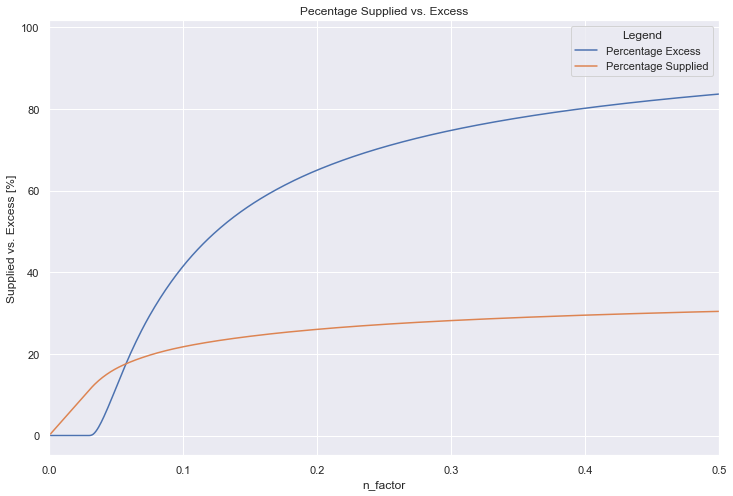

In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

temp = Results_df['Measured'][['n_factor', 'Percentage Excess', 'Percentage Supplied']]
temp = temp.apply(pd.to_numeric, errors='coerce')
# convert to long (tidy) form
tempm = temp.melt('n_factor', var_name='Legend', value_name='Supplied_vs_Excess')
# convert to long (tidy) form
# dfm = df.melt('X_Axis', var_name='cols', value_name='vals')

temp1 = Results_df['Measured'][['n_factor', 'Percentage Excess', 'Percentage Supplied']]
temp1 = temp.apply(pd.to_numeric, errors='coerce')
# convert to long (tidy) form
tempm1 = temp1.melt('n_factor', var_name='Legend', value_name='Supplied_vs_Excess')
# convert to long (tidy) form
# dfm = df.melt('X_Axis', var_name='cols', value_name='vals')

g = sns.lineplot(data = temp, x = tempm['n_factor'], y = tempm['Supplied_vs_Excess'], hue = tempm['Legend'])
# g.addFi.lineplot(data = temp, x = tempm['n_factor'], y = tempm['Supplied_vs_Excess'], hue = tempm['Legend'])
#add overall title to replot
g.set_ylabel("Supplied vs. Excess [%]")
g.set(title = 'Pecentage Supplied vs. Excess')
sns.set(rc={"figure.figsize":(12, 8)}) #width=3, #height=4
g.set(xlim = (0,0.5))

# Boxplots: % Utilization, % Export of Actual and Synth

In [30]:
temp = PV_Results_df2

In [31]:
temp['Supplied Error'] = temp['Measured']['Percentage Supplied'] - temp['Synthetic']['Percentage Supplied']#/temp['Measured']['Supplied']
temp['Excess Error'] = temp['Measured']['Percentage Excess'] - temp['Synthetic']['Percentage Excess']#/temp['Measured']['Excess']

In [32]:
temp1 = temp[['Supplied Error', 'Excess Error']]
temp1 = temp1.droplevel(1, axis = 1)

[Text(0, 0.5, 'Percentage Error [%]')]

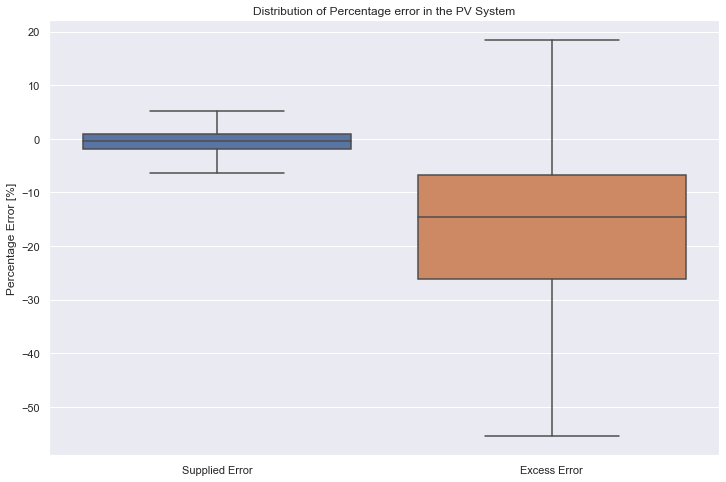

In [33]:
g = sns.boxplot(data = temp1, showfliers = False)
g.set(title = "Distribution of Percentage error in the PV System")
sns.set(rc={"figure.figsize":(8,18)}) #width=3, #height=4
# g.set_xticks([0,1])
# g.show(legend = True)
g.set(ylabel =("Percentage Error [%]"))
# g.set_xticklabels(['Under', 'Over'])

In [79]:
# PV_Results_df2.drop(['Supplied Error','Excess Error','Synthetic Utilisation', 'Actual Utilisation', 'Synthetic Exported', 'Actual Exported'], axis = 1, inplace = True)

In [105]:
PV_Results_df2.columns.levels[1]

Index(['Excess', 'Percentage Excess', 'Percentage Supplied', 'Supplied',
       'n_factor', ''],
      dtype='object')

In [49]:
PV_Results_df2

Measured                                                   \
         n_factor Percentage Excess     Excess Percentage Supplied   
1           0.042          5.398119  50.271764           14.742287   
10          0.042          5.398119  50.271764           14.742287   
11          0.042          5.398119  50.271764           14.742287   
12          0.042          5.398119  50.271764           14.742287   
13          0.042          5.398119  50.271764           14.742287   
...           ...               ...        ...                 ...   
12023511    0.042          5.398119  50.271764           14.742287   
12023533    0.042          5.398119  50.271764           14.742287   
12023550    0.042          5.398119  50.271764           14.742287   
12023567    0.042          5.398119  50.271764           14.742287   
12023576    0.042          5.398119  50.271764           14.742287   

                             Synthetic                                  \
            Supplied Percentage Excess      Excess Percentage Supplied   
1         881.011252          18.03102  167.919823           19.082612   
10        881.011252          18.03102  167.919823           19.082612   
11        881.011252          18.03102  167.919823           19.082612   
12        881.011252          18.03102  167.919823           19.082612   
13        881.011252          18.03102  167.919823           19.082612   
...              ...               ...         ...                 ...   
12023511  881.011252          18.03102  167.919823           19.082612   
12023533  881.011252          18.03102  167.919823           19.082612   
12023550  881.011252          18.03102  167.919823           19.082612   
12023567  881.011252          18.03102  167.919823           19.082612   
12023576  881.011252          18.03102  167.919823           19.082612   

                      
            Supplied  
1         763.363193  
10        763.363193  
11        763.363193  
12        763.363193  
13        763.363193  
...              ...  
12023511  763.363193  
12023533  763.363193  
12023550  763.363193  
12023567  763.363193  
12023576  763.363193  

[3182 rows x 9 columns]

In [257]:
temporary = PV_Results_df1.copy()
temporary.columns = temporary.columns.values
temporary.columns = pd.MultiIndex.from_tuples(temporary.rename(columns={('Measured', 'Percentage Excess'): ('Measured', 'M Excess'), ('Measured', 'Percentage Supplied'): ('Measured', 'M Supplied'),
                                                                            ('Synthetic', 'Percentage Excess'): ('Synthetic', 'S Excess'), ('Synthetic', 'Percentage Supplied'): ('Synthetic', 'S Supplied')}))
temporary = temporary.drop(['n_factor', 'Excess', 'Supplied'], axis = 1, level = 1)
d = dict(zip(temporary.columns.levels[1], ['','Exported','Utilisation','Exported','Utilisation']))
temporary = temporary.rename(columns=d, level=1)

# # temporary.columns = temporary.columns.set_levels(['Exported Act','Utilisation Act','Exported Synth','Utilisation Synth'],level=1)
temporary = pd.melt(temporary)
temporary.at[temporary['variable_0'] == 'Measured',['variable_0']] = 'Actual'
# temporary = temporary.unstack().reset_index()#.drop('level_0', axis=1)
# temporary = temporary.stack().reset_index()
temporary.columns = ['Legend', '', 'Percentage [%]']
temporary

# temporary['Synthetic Utilisation'] = PV_Results_df2['Synthetic']['Percentage Supplied']
# temporary['Actual Utilisation'] = PV_Results_df2['Measured']['Percentage Supplied']
# temporary['Synthetic Exported'] = PV_Results_df2['Synthetic']['Percentage Excess']
# temporary['Actual Exported'] = PV_Results_df2['Measured']['Percentage Excess']

,Legend,,Percentage [%]
0,Actual,Exported,0.0
1,Actual,Exported,0.305004
2,Actual,Exported,0.011024
3,Actual,Exported,0.501299
4,Actual,Exported,28.758369
...,...,...,...
12723,Synthetic,Utilisation,5.588562
12724,Synthetic,Utilisation,3.838935
12725,Synthetic,Utilisation,1.98669
12726,Synthetic,Utilisation,2.114314


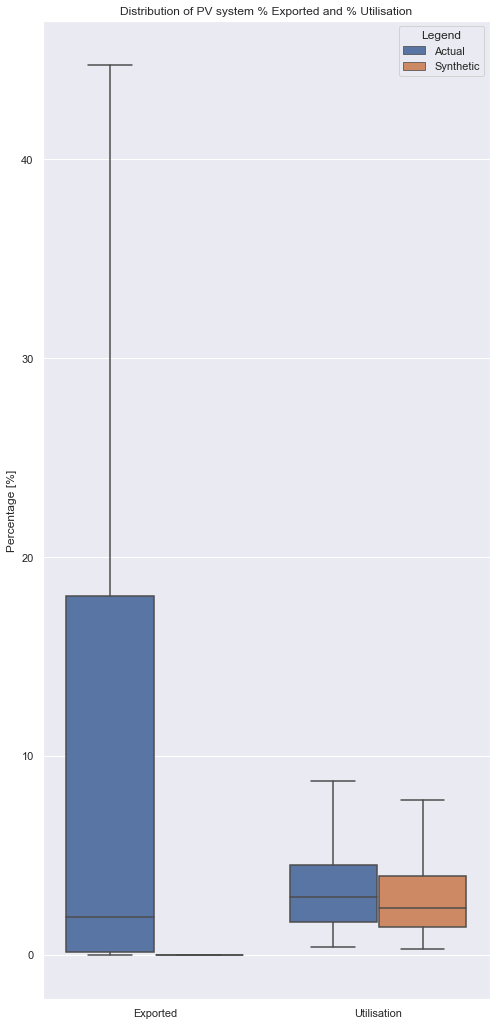

In [258]:
g = sns.boxplot(x = temporary[''],y = temporary['Percentage [%]'], hue = temporary['Legend'], showfliers = False)
g.set(title = "Distribution of PV system % Exported and % Utilisation")
sns.set(rc={"figure.figsize":(8,18)}) #width=3, #height=4
# g.set_xticks([0,1])
# g.show(legend = True)
# g.set(ylabel =("Percentage Error [%]"))

In [42]:
PV_Results_df2.loc[1186]

Measured   n_factor                    0.042
           Percentage Excess        5.398119
           Excess                  50.271764
           Percentage Supplied     14.742287
           Supplied               881.011252
Synthetic  Percentage Excess        18.03102
           Excess                 167.919823
           Percentage Supplied     19.082612
           Supplied               763.363193
Name: 1186, dtype: object

In [78]:
temporary['Percentage [%]'] = pd.to_numeric(temporary['Percentage [%]'])

# Violin Plot

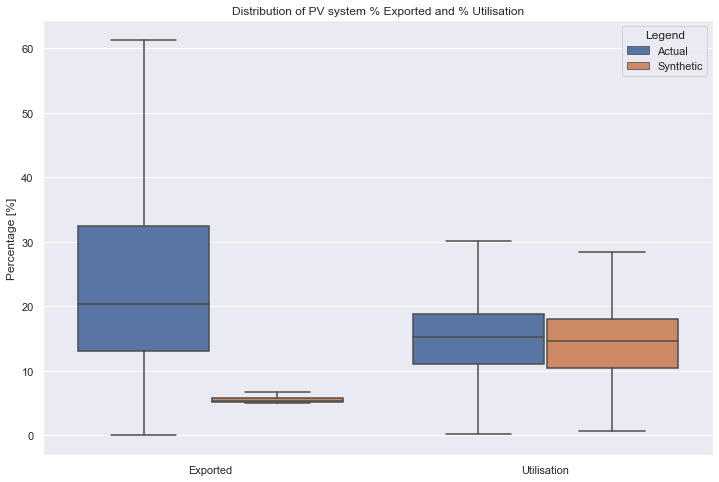

In [93]:
g = sns.violinplot(x = '',y = 'Percentage [%]', hue = 'Legend', data = temporary, showfliers = False, cut = 0)
g.set(title = "Distribution of PV system % Exported and % Utilisation")
sns.set(rc={"figure.figsize":(8,18)}) #width=3, #height=4

In [148]:
temporary['Percentage [%]'] = pd.to_numeric(temporary['Percentage [%]'], errors ='ignore')

# Calculate the average daily consumption of a user

In [94]:
data = pd.read_pickle('sorted_households.pkl') # Read pickle file

In [95]:
pv_df_temp = PV_Results_df2.copy()#drop(['Supplied Error','Excess Error'], axis = 1).
pv_50_150 = pv_df_temp.loc[pv_df_temp.index.isin(data['50_150']), : ]
pv_150_400 = pv_df_temp.loc[pv_df_temp.index.isin(data['150_400']), : ]
pv_400_600 = pv_df_temp.loc[pv_df_temp.index.isin(data['400_600']), : ]
pv_600_1200 = pv_df_temp.loc[pv_df_temp.index.isin(data['600_1200']), : ]
pv_1200_2500 = pv_df_temp.loc[pv_df_temp.index.isin(data['1200_2500']), : ]

# PV_Results_df2.loc[data['50_150']] 
# # df_150_400.loc[data['150_400']]
# # df_400_600.loc[data['400_600']] 
# # df_600_1200.loc[data['600_1200']] 
# # df_1200_2500.loc[data['1200_2500']] 

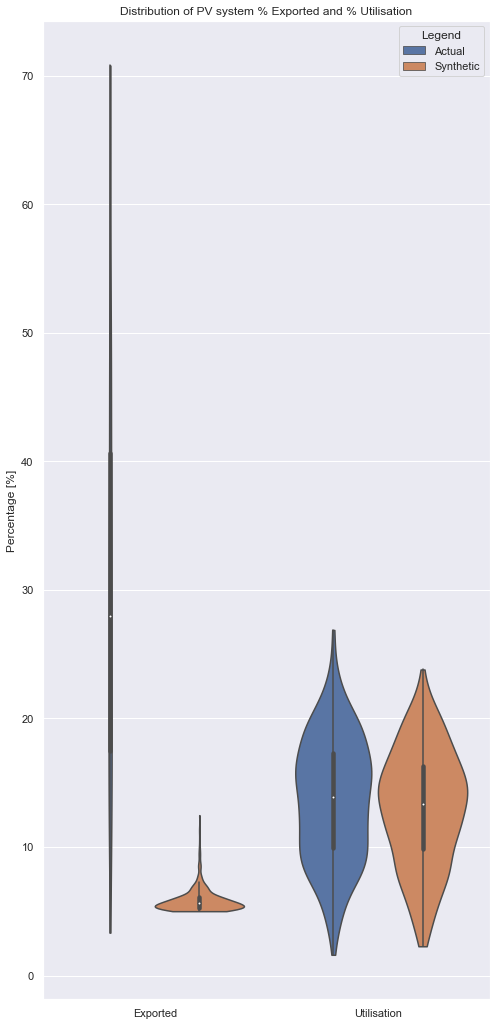

In [96]:
temporary = pv_50_150.copy()
temporary.columns = temporary.columns.values
temporary.columns = pd.MultiIndex.from_tuples(temporary.rename(columns={('Measured', 'Percentage Excess'): ('Measured', 'M Excess'), ('Measured', 'Percentage Supplied'): ('Measured', 'M Supplied'),
                                                                            ('Synthetic', 'Percentage Excess'): ('Synthetic', 'S Excess'), ('Synthetic', 'Percentage Supplied'): ('Synthetic', 'S Supplied')}))
temporary = temporary.drop(['n_factor', 'Excess', 'Supplied'], axis = 1, level = 1)
d = dict(zip(temporary.columns.levels[1], ['','Exported','Utilisation','Exported','Utilisation']))
temporary = temporary.rename(columns=d, level=1)

# # temporary.columns = temporary.columns.set_levels(['Exported Act','Utilisation Act','Exported Synth','Utilisation Synth'],level=1)
temporary = pd.melt(temporary)
temporary.at[temporary['variable_0'] == 'Measured',['variable_0']] = 'Actual'
# temporary = temporary.unstack().reset_index()#.drop('level_0', axis=1)
# temporary = temporary.stack().reset_index()
temporary.columns = ['Legend', '', 'Percentage [%]']
temporary
temporary['Percentage [%]'] = pd.to_numeric(temporary['Percentage [%]'], errors ='ignore')

g = sns.violinplot(x = '',y = 'Percentage [%]', hue = 'Legend', data = temporary, showfliers = False, cut = 0)
g.set(title = "Distribution of PV system % Exported and % Utilisation")
sns.set(rc={"figure.figsize":(8,18)}) #width=3, #height=4

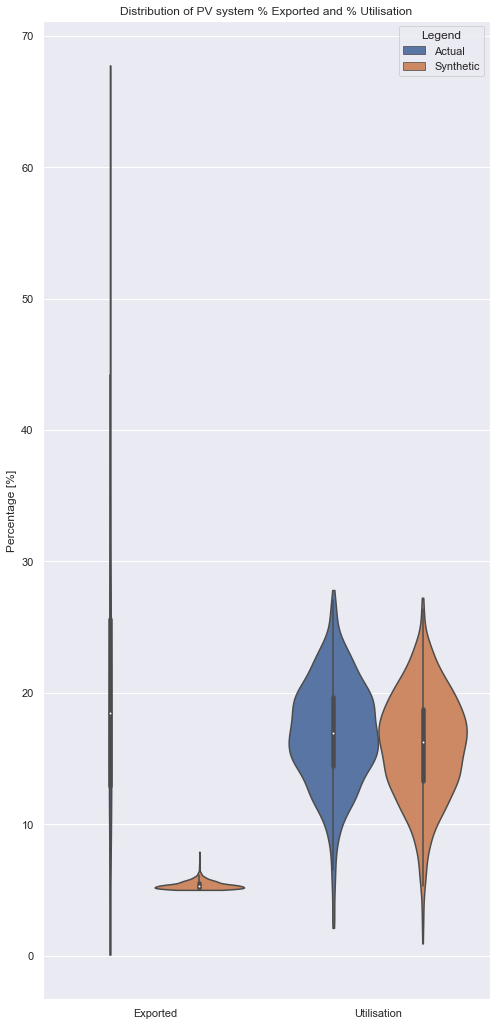

In [97]:
temporary = pv_150_400.copy()
temporary.columns = temporary.columns.values
temporary.columns = pd.MultiIndex.from_tuples(temporary.rename(columns={('Measured', 'Percentage Excess'): ('Measured', 'M Excess'), ('Measured', 'Percentage Supplied'): ('Measured', 'M Supplied'),
                                                                            ('Synthetic', 'Percentage Excess'): ('Synthetic', 'S Excess'), ('Synthetic', 'Percentage Supplied'): ('Synthetic', 'S Supplied')}))
temporary = temporary.drop(['n_factor', 'Excess', 'Supplied'], axis = 1, level = 1)
d = dict(zip(temporary.columns.levels[1], ['','Exported','Utilisation','Exported','Utilisation']))
temporary = temporary.rename(columns=d, level=1)

# # temporary.columns = temporary.columns.set_levels(['Exported Act','Utilisation Act','Exported Synth','Utilisation Synth'],level=1)
temporary = pd.melt(temporary)
temporary.at[temporary['variable_0'] == 'Measured',['variable_0']] = 'Actual'
# temporary = temporary.unstack().reset_index()#.drop('level_0', axis=1)
# temporary = temporary.stack().reset_index()
temporary.columns = ['Legend', '', 'Percentage [%]']
temporary
temporary['Percentage [%]'] = pd.to_numeric(temporary['Percentage [%]'], errors ='ignore')

g = sns.violinplot(x = '',y = 'Percentage [%]', hue = 'Legend', data = temporary, showfliers = False, cut = 0)
g.set(title = "Distribution of PV system % Exported and % Utilisation")
sns.set(rc={"figure.figsize":(8,18)}) #width=3, #height=4

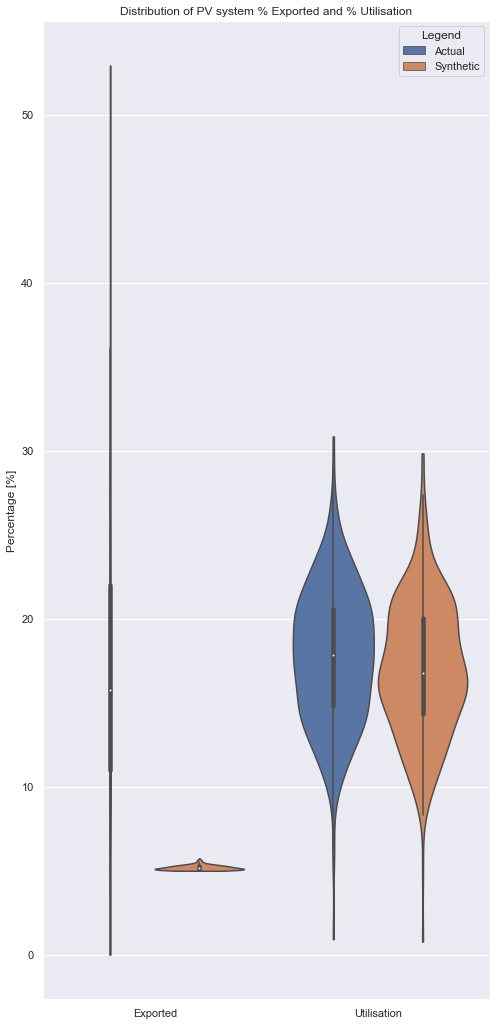

In [98]:
temporary = pv_400_600.copy()
temporary.columns = temporary.columns.values
temporary.columns = pd.MultiIndex.from_tuples(temporary.rename(columns={('Measured', 'Percentage Excess'): ('Measured', 'M Excess'), ('Measured', 'Percentage Supplied'): ('Measured', 'M Supplied'),
                                                                            ('Synthetic', 'Percentage Excess'): ('Synthetic', 'S Excess'), ('Synthetic', 'Percentage Supplied'): ('Synthetic', 'S Supplied')}))
temporary = temporary.drop(['n_factor', 'Excess', 'Supplied'], axis = 1, level = 1)
d = dict(zip(temporary.columns.levels[1], ['','Exported','Utilisation','Exported','Utilisation']))
temporary = temporary.rename(columns=d, level=1)

# # temporary.columns = temporary.columns.set_levels(['Exported Act','Utilisation Act','Exported Synth','Utilisation Synth'],level=1)
temporary = pd.melt(temporary)
temporary.at[temporary['variable_0'] == 'Measured',['variable_0']] = 'Actual'
# temporary = temporary.unstack().reset_index()#.drop('level_0', axis=1)
# temporary = temporary.stack().reset_index()
temporary.columns = ['Legend', '', 'Percentage [%]']
temporary
temporary['Percentage [%]'] = pd.to_numeric(temporary['Percentage [%]'], errors ='ignore')

g = sns.violinplot(x = '',y = 'Percentage [%]', hue = 'Legend', data = temporary, showfliers = False, cut = 0)
g.set(title = "Distribution of PV system % Exported and % Utilisation")
sns.set(rc={"figure.figsize":(8,18)}) #width=3, #height=4

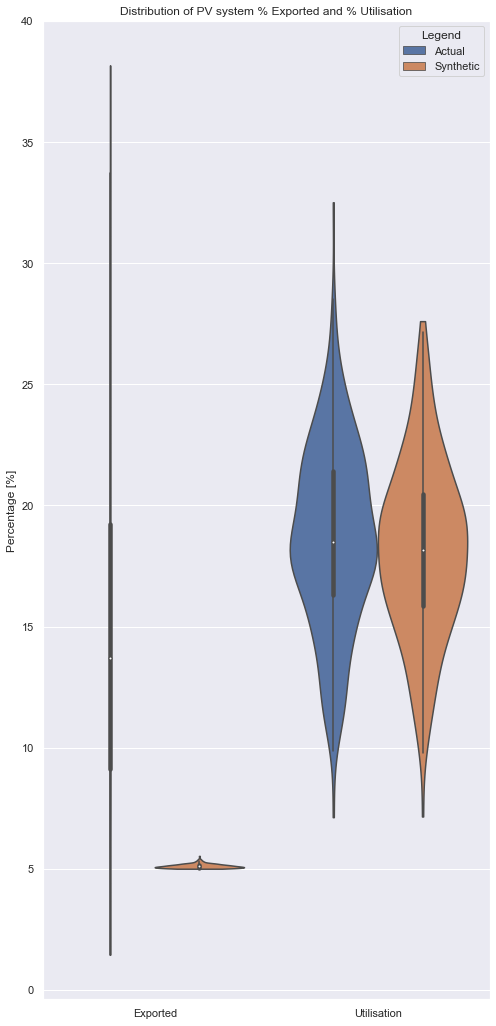

In [99]:
temporary = pv_600_1200.copy()
temporary.columns = temporary.columns.values
temporary.columns = pd.MultiIndex.from_tuples(temporary.rename(columns={('Measured', 'Percentage Excess'): ('Measured', 'M Excess'), ('Measured', 'Percentage Supplied'): ('Measured', 'M Supplied'),
                                                                            ('Synthetic', 'Percentage Excess'): ('Synthetic', 'S Excess'), ('Synthetic', 'Percentage Supplied'): ('Synthetic', 'S Supplied')}))
temporary = temporary.drop(['n_factor', 'Excess', 'Supplied'], axis = 1, level = 1)
d = dict(zip(temporary.columns.levels[1], ['','Exported','Utilisation','Exported','Utilisation']))
temporary = temporary.rename(columns=d, level=1)

# # temporary.columns = temporary.columns.set_levels(['Exported Act','Utilisation Act','Exported Synth','Utilisation Synth'],level=1)
temporary = pd.melt(temporary)
temporary.at[temporary['variable_0'] == 'Measured',['variable_0']] = 'Actual'
# temporary = temporary.unstack().reset_index()#.drop('level_0', axis=1)
# temporary = temporary.stack().reset_index()
temporary.columns = ['Legend', '', 'Percentage [%]']
temporary
temporary['Percentage [%]'] = pd.to_numeric(temporary['Percentage [%]'], errors ='ignore')

g = sns.violinplot(x = '',y = 'Percentage [%]', hue = 'Legend', data = temporary, showfliers = False, cut = 0)
g.set(title = "Distribution of PV system % Exported and % Utilisation")
sns.set(rc={"figure.figsize":(8,18)}) #width=3, #height=4

In [70]:
PV_Results_df2.drop(['Supplied Error','Excess Error'], axis = 1, inplace = True)

In [100]:
quantile_25 = PV_Results_df2['Measured']['Percentage Excess'].quantile(0.25)
quantile_50 = PV_Results_df2['Measured']['Percentage Excess'].quantile(0.50)
quantile_75 = PV_Results_df2['Measured']['Percentage Excess'].quantile(0.75)
# quantile_25 = PV_Results_df2['Measured']['Percentage Excess'].quantile(0.25)

In [101]:
quantile_25_df = PV_Results_df2[PV_Results_df2['Measured']['Percentage Excess'] < quantile_25]
quantile_50_df = PV_Results_df2[PV_Results_df2['Measured']['Percentage Excess'] < quantile_50]
quantile_75_df = PV_Results_df2[PV_Results_df2['Measured']['Percentage Excess'] < quantile_75]

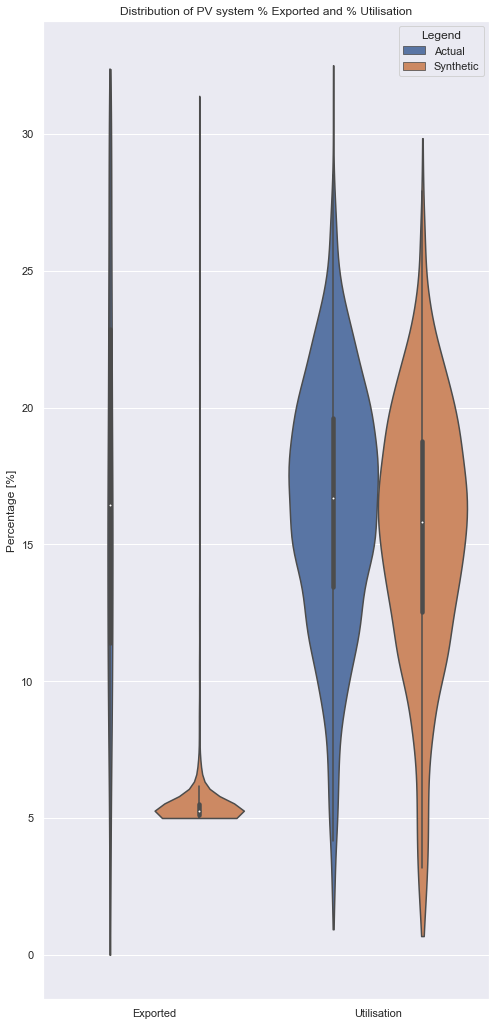

In [102]:
temporary = quantile_75_df.copy()
temporary.columns = temporary.columns.values
temporary.columns = pd.MultiIndex.from_tuples(temporary.rename(columns={('Measured', 'Percentage Excess'): ('Measured', 'M Excess'), ('Measured', 'Percentage Supplied'): ('Measured', 'M Supplied'),
                                                                            ('Synthetic', 'Percentage Excess'): ('Synthetic', 'S Excess'), ('Synthetic', 'Percentage Supplied'): ('Synthetic', 'S Supplied')}))
temporary = temporary.drop(['n_factor', 'Excess', 'Supplied'], axis = 1, level = 1)
d = dict(zip(temporary.columns.levels[1], ['','Exported','Utilisation','Exported','Utilisation']))
temporary = temporary.rename(columns=d, level=1)

# # temporary.columns = temporary.columns.set_levels(['Exported Act','Utilisation Act','Exported Synth','Utilisation Synth'],level=1)
temporary = pd.melt(temporary)
temporary.at[temporary['variable_0'] == 'Measured',['variable_0']] = 'Actual'
# temporary = temporary.unstack().reset_index()#.drop('level_0', axis=1)
# temporary = temporary.stack().reset_index()
temporary.columns = ['Legend', '', 'Percentage [%]']
temporary
temporary['Percentage [%]'] = pd.to_numeric(temporary['Percentage [%]'], errors ='ignore')

g = sns.violinplot(x = '',y = 'Percentage [%]', hue = 'Legend', data = temporary, showfliers = False, cut = 0)
g.set(title = "Distribution of PV system % Exported and % Utilisation")
sns.set(rc={"figure.figsize":(8,18)}) #width=3, #height=4

# Create % Utilisation Boxplots

# For the different years electrified groups

In [15]:
dels_df = pd.read_csv(r"data/survey_data/delskv-1994-2014.csv",  header=[0], index_col = 0)

In [16]:
years_electrified_df = dels_df['years_electrified'].dropna()

In [17]:
years_electrified_df = years_electrified_df.to_frame()

In [18]:
years_electrified_df = years_electrified_df[years_electrified_df.index.isin(profileIDs)]

In [19]:
years_electrified_df

,years_electrified
ProfileID,
1185,8.0
1186,2.0
1222,10.0
1223,5.0
1225,7.0


In [20]:
PV_Results_temp = PV_Results_df3[PV_Results_df3.index.isin(years_electrified_df.index)]

In [21]:
PV_Results_temp

Measured                                                                  \
     n_factor Percentage Excess       Excess Percentage Supplied     Supplied   
1185    0.204         34.269828  1550.152697            25.75533  2973.221949   
1186    0.146         38.206477  1236.864822           22.468104  2000.452327   
1222    0.177          37.58344  1475.034515           26.968835  2449.658193   
1223    0.109         33.602807   812.146636           21.795842  1604.754523   
1225    0.149         35.153228  1161.405485           20.138224  2142.431879   

     Synthetic                                                                 
      n_factor Percentage Excess      Excess Percentage Supplied     Supplied  
1185     0.204         15.124365  684.131709           24.898838  3839.242937  
1186     0.146         15.263113  494.115388           25.320473   2743.20176  
1222     0.177         15.076059  591.688994           28.184694  3333.003713  
1223     0.109         15.011855  362.821693           20.236212  2054.079466  
1225     0.149         15.162629  500.948614           20.132748   2802.88875

In [22]:
years_electrified_df = years_electrified_df.sort_index()

In [23]:
merged_df = pd.merge(years_electrified_df, PV_Results_temp, left_index=True, right_index=True)

c:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\reshape\merge.py:648: UserWarning:

merging between different levels can give an unintended result (1 levels on the left,2 on the right)



In [24]:
years_electrified_df.loc[(years_electrified_df.years_electrified < 5.0),'years_electrified_str'] = '5 years'
years_electrified_df.loc[(years_electrified_df.years_electrified > 5.0) & (years_electrified_df.years_electrified < 10.0),'years_electrified_str'] = '10 years'
years_electrified_df.loc[(years_electrified_df.years_electrified > 10.0) & (years_electrified_df.years_electrified < 15.0),'years_electrified_str'] = '15 years'
years_electrified_df.loc[(years_electrified_df.years_electrified > 15.0),'years_electrified_str'] = '+ 15 years'

In [25]:
temporary = PV_Results_temp.copy()
temporary.columns = temporary.columns.values
temporary.columns = pd.MultiIndex.from_tuples(temporary.rename(columns={('Measured', 'Percentage Excess'): ('Measured', 'M Excess'), ('Measured', 'Percentage Supplied'): ('Measured', 'M Supplied'),
                                                                            ('Synthetic', 'Percentage Excess'): ('Synthetic', 'S Excess'), ('Synthetic', 'Percentage Supplied'): ('Synthetic', 'S Supplied')}))
# temporary = temporary.drop(['n_factor', 'Excess', 'Supplied'], axis = 1, level = 1)
# d = dict(zip(temporary.columns.levels[1], ['','Exported','Utilisation','Exported','Utilisation']))
# temporary = temporary.rename(columns=d, level=1)
temporary = temporary.droplevel(level = 0, axis = 1)
merged_df = pd.merge(years_electrified_df, temporary, left_index=True, right_index=True)
merged_df
# # # temporary.columns = temporary.columns.set_levels(['Exported Act','Utilisation Act','Exported Synth','Utilisation Synth'],level=1)
# temporary = pd.melt(temporary)
# temporary.at[temporary['variable_0'] == 'Measured',['variable_0']] = 'Actual'
# # temporary = temporary.unstack().reset_index()#.drop('level_0', axis=1)
# # temporary = temporary.stack().reset_index()
# temporary.columns = ['Legend', '', 'Percentage [%]']
# temporary

# temporary['Synthetic Utilisation'] = PV_Results_df2['Synthetic']['Percentage Supplied']
# temporary['Actual Utilisation'] = PV_Results_df2['Measured']['Percentage Supplied']
# temporary['Synthetic Exported'] = PV_Results_df2['Synthetic']['Percentage Excess']
# temporary['Actual Exported'] = PV_Results_df2['Measured']['Percentage Excess']

,years_electrified,years_electrified_str,n_factor,M Excess,Excess,M Supplied,Supplied,n_factor,S Excess,Excess,S Supplied,Supplied
ProfileID,,,,,,,,,,,,
1185,8.0,10 years,0.204,34.269828,1550.152697,25.75533,2973.221949,0.204,15.124365,684.131709,24.898838,3839.242937
1186,2.0,5 years,0.146,38.206477,1236.864822,22.468104,2000.452327,0.146,15.263113,494.115388,25.320473,2743.20176
1222,10.0,NaN,0.177,37.58344,1475.034515,26.968835,2449.658193,0.177,15.076059,591.688994,28.184694,3333.003713
1223,5.0,NaN,0.109,33.602807,812.146636,21.795842,1604.754523,0.109,15.011855,362.821693,20.236212,2054.079466
1225,7.0,10 years,0.149,35.153228,1161.405485,20.138224,2142.431879,0.149,15.162629,500.948614,20.132748,2802.88875


In [26]:
merged_temp = merged_df.drop(['years_electrified','n_factor','M Excess','S Excess','Excess','Supplied','Excess','Supplied'], axis = 1)
merged_temp.years_electrified_str.unique()

array(['10 years', '5 years', nan], dtype=object)

In [27]:
df1 = merged_temp[merged_temp['years_electrified_str'] == '5 years']
df2 = merged_temp[merged_temp['years_electrified_str'] == '10 years']
df3 = merged_temp[merged_temp['years_electrified_str'] == '15 years']
df4 = merged_temp[merged_temp['years_electrified_str'] == '+ 15 years']
# mergerd_temporary.at[mergerd_temporary['variable_0'] == 'Measured',['variable_0']] = 'Actual'
# temporary = temporary.unstack().reset_index()#.drop('level_0', axis=1)
# temporary = temporary.stack().reset_index()
# mergerd_temporary.columns = ['Legend', '', 'Percentage [%]']

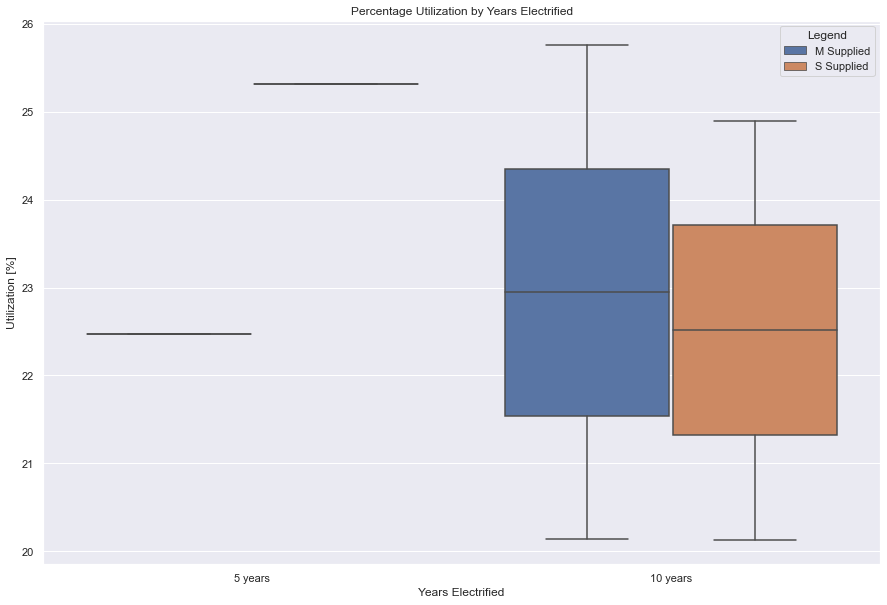

In [31]:
cdf = pd.concat([df1, df2, df3, df4])                                # CONCATENATE
mdf = pd.melt(cdf, id_vars=['years_electrified_str'], var_name=['Legend'])      # MELT

ax = sns.boxplot(x="years_electrified_str", y="value", hue="Legend", data=mdf, showfliers = False)  # RUN PLOT   
ax.set(xlabel = "Years Electrified", ylabel = "Utilization [%]", title = "Percentage Utilization by Years Electrified")
sns.set(rc={"figure.figsize":(15,10)}) #width=3, #height=4
# plt.show()

# plt.clf()
# plt.close()

# Plot the % Exported error

In [14]:
temp = PV_Results_df3.copy()
temp1 = pd.DataFrame()
temp1['Excess Error'] = np.abs(temp['Measured']['Percentage Excess'] - temp['Synthetic']['Percentage Excess'])#/temp['Measured']['Excess']
# temp1 = temp1.droplevel(1, axis = 1)
# temp1 = temp[ 'Excess Error']
temp1_merged_df = pd.merge(years_electrified_df, temp1, left_index=True, right_index=True)
temp1_merged_df.drop('years_electrified', axis = 1 , inplace = True)

df1 = temp1_merged_df[temp1_merged_df.years_electrified_str == "5 years"]
df2 = temp1_merged_df[temp1_merged_df.years_electrified_str == "10 years"]
df3 = temp1_merged_df[temp1_merged_df.years_electrified_str == "15 years"]
df4 = temp1_merged_df[temp1_merged_df.years_electrified_str == "+ 15 years"]

cdf = pd.concat([df1, df2, df3, df4])                                # CONCATENATE
mdf = pd.melt(cdf, id_vars=['years_electrified_str'], var_name=['Legend'])      # MELT

ax = sns.boxplot(x="years_electrified_str", y="value", hue="years_electrified_str", data=mdf, showfliers = False)  # RUN PLOT   
ax.set(xlabel = "Years Electrified", ylabel = "Difference [%]", title = "Percentage Exported Difference by Years Electrified")
sns.set(rc={"figure.figsize":(15,10)}) #width=3, #height=4
plt.show()

plt.clf()
plt.close()

NameError: name 'years_electrified_df' is not defined

In [280]:
temp1[temp1['Excess Error'] < 1]

,Excess Error
27,0.575722
134,0.479566
689,0.353028
864,0.184874
886,0.055329
...,...
12022098,0.364725
12022406,0.8093
12022562,0.392583
12022610,0.653216


In [281]:
PV_Results_df2.loc[886]

Measured   n_factor                     0.071
           Percentage Excess         5.147176
           Excess                   81.032605
           Percentage Supplied      12.508216
           Supplied               1493.279159
Synthetic  Percentage Excess         5.091848
           Excess                   80.161559
           Percentage Supplied      10.052312
           Supplied               1494.150205
Name: 886, dtype: object

# Boxplot of the system size difference

In [13]:
PV_Results_df3

Measured                                                    \
         n_factor Percentage Excess      Excess Percentage Supplied   
1           0.039         15.357617  132.806963           18.297489   
10          0.072         15.177514  242.306766           20.745554   
11          0.076         15.114913  254.713312           21.057587   
12          0.028         15.532203   96.432512           14.992472   
13          0.003         19.522776   12.986593            7.457747   
...           ...               ...         ...                 ...   
12023511    0.001         50.545956    11.20776            1.134907   
12023533    0.001         70.151445   15.554964            0.787383   
12023550    0.012         15.062272   40.077824              8.2148   
12023567    0.001         31.911208    7.075801            0.548811   
12023576    0.011         17.081303   41.662571           11.748212   

                      Synthetic                                \
             Supplied  n_factor Percentage Excess      Excess   
1          731.955837     0.055         15.683961  191.271754   
10        1354.178404      0.07         15.289493  237.314083   
11        1430.465478     0.095         15.002383  316.021217   
12         524.422831     0.046         15.257446  155.622389   
13          53.533623      0.01          15.41372   34.177465   
...               ...       ...               ...         ...   
12023511    10.965646     0.006         16.383298    21.79641   
12023533     6.618441     0.004         19.114948   16.953739   
12023550   226.003038      0.04         15.149436  134.365831   
12023567    15.097604     0.032         15.324184  108.732589   
12023576   202.244886     0.031         15.616709  107.345438   

                                           
         Percentage Supplied     Supplied  
1                  17.206348  1028.265528  
10                 21.201245  1314.824276  
11                 25.471406   1790.45227  
12                 22.214179   864.354247  
13                 16.378476   187.556586  
...                      ...          ...  
12023511            6.566676   111.244021  
12023533             3.24814    71.739881  
12023550           13.485741   752.570374  
12023567              11.458   600.816375  
12023576           23.807232   580.030121  

[3182 rows x 10 columns]

In [19]:
measured_df = PV_Results_df3['Measured']['n_factor'].to_frame()

In [20]:
synthetic_df = PV_Results_df3['Synthetic']['n_factor'].to_frame()

In [36]:
measured_df['Measured'] = measured_df['n_factor']*14.1

In [38]:
synthetic_df['Synthetic'] = synthetic_df['n_factor']*14.1

In [45]:
df1

,Synthetic
1,0.7755
10,0.987
11,1.3395
12,0.6486
13,0.141
...,...
12023511,0.0846
12023533,0.0564
12023550,0.564
12023567,0.4512


In [46]:
df2

,Measured
1,0.5499
10,1.0152
11,1.0716
12,0.3948
13,0.0423
...,...
12023511,0.0141
12023533,0.0141
12023550,0.1692
12023567,0.0141


In [78]:
df1['Error'] = df1['Synthetic'] - df2['Measured']

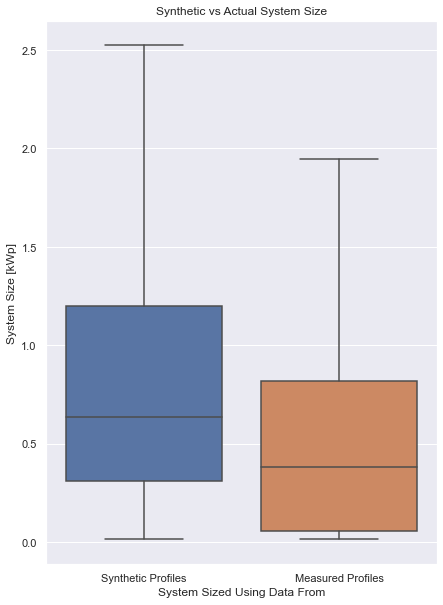

In [77]:
df1 = synthetic_df['Synthetic'].to_frame()
df2 = measured_df['Measured'].to_frame()

cdf = pd.concat([df1, df2])                                # CONCATENATE
mdf = pd.melt(cdf, var_name=['Legend'])      # MELT

ax = sns.boxplot(data=cdf, showfliers = False)  # RUN PLOT   
ax.set(xlabel = "System Sized Using Data From", ylabel = "System Size [kWp]", title = "Synthetic vs Actual System Size")
ax.set_xticklabels(["Synthetic Profiles", "Measured Profiles"])
sns.set(rc={"figure.figsize":(8,10)}) #width=3, #height=4
# plt.show()

# plt.clf()
# plt.close()

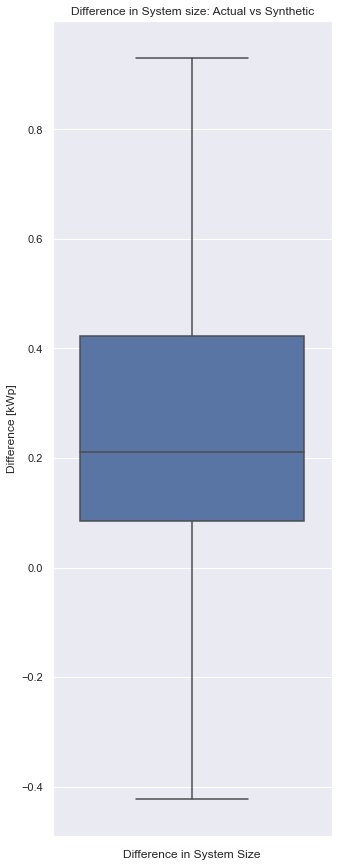

In [81]:
ax = sns.boxplot(data=df1['Error'].to_frame(), showfliers = False)  # RUN PLOT   
ax.set(xlabel = "Difference in System Size", ylabel = "Difference [kWp]", title = "Difference in System size: Actual vs Synthetic")
ax.set_xticklabels('')
sns.set(rc={"figure.figsize":(5,12)}) #width=3, #height=4

In [74]:
df1['% Error'] = ((df1['Synthetic'] - df2['Measured'])/df1['Synthetic'])*100

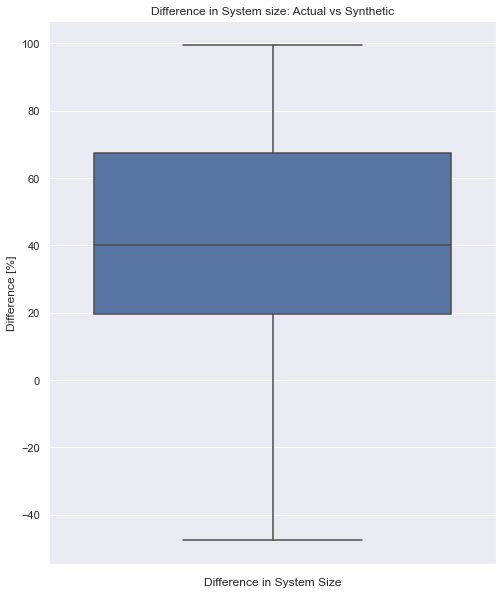

In [75]:
ax = sns.boxplot(data=df1['% Error'].to_frame(), showfliers = False)  # RUN PLOT   
ax.set(xlabel = "Difference in System Size", ylabel = "Difference [%]", title = "Difference in System size: Actual vs Synthetic")
ax.set_xticklabels('')
sns.set(rc={"figure.figsize":(7,10)}) #width=3, #height=4

In [32]:
PV_Results_df3

Measured                                                                  \
     n_factor Percentage Excess       Excess Percentage Supplied     Supplied   
1185    0.204         34.269828  1550.152697            25.75533  2973.221949   
1186    0.146         38.206477  1236.864822           22.468104  2000.452327   
1222    0.177          37.58344  1475.034515           26.968835  2449.658193   
1223    0.109         33.602807   812.146636           21.795842  1604.754523   
1225    0.149         35.153228  1161.405485           20.138224  2142.431879   

     Synthetic                                                                 
      n_factor Percentage Excess      Excess Percentage Supplied     Supplied  
1185     0.204         15.124365  684.131709           24.898838  3839.242937  
1186     0.146         15.263113  494.115388           25.320473   2743.20176  
1222     0.177         15.076059  591.688994           28.184694  3333.003713  
1223     0.109         15.011855  362.821693           20.236212  2054.079466  
1225     0.149         15.162629  500.948614           20.132748   2802.88875

In [33]:
PV_Results_df3.to_csv("PV_Results_model_trained_with_one_year_of_data.csv")

In [6]:
PV_Results_df3 = pd.read_csv("PV_Results_model_trained_with_one_year_of_data.csv", header  = [0,1],index_col=[0], )

In [7]:
PV_Results_df3

Measured                                                                  \
     n_factor Percentage Excess       Excess Percentage Supplied     Supplied   
1185    0.204         34.269828  1550.152697           25.755330  2973.221949   
1186    0.146         38.206477  1236.864822           22.468104  2000.452327   
1222    0.177         37.583440  1475.034515           26.968835  2449.658193   
1223    0.109         33.602807   812.146636           21.795842  1604.754523   
1225    0.149         35.153228  1161.405485           20.138224  2142.431879   

     Synthetic                                                                 
      n_factor Percentage Excess      Excess Percentage Supplied     Supplied  
1185     0.204         15.124365  684.131709           24.898838  3839.242937  
1186     0.146         15.263113  494.115388           25.320473  2743.201760  
1222     0.177         15.076059  591.688994           28.184694  3333.003713  
1223     0.109         15.011855  362.821693           20.236212  2054.079466  
1225     0.149         15.162629  500.948614           20.132748  2802.888750